In [1]:
import logging
import os
import re
from pathlib import Path
from typing import Dict, Iterable, List, Sequence

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import hwt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import properscoring as ps
import requests
import xarray as xr
import xesmf as xe
from dask.distributed import Client, LocalCluster
from metpy.constants import g
from tqdm.notebook import tqdm

# Place where Dave cached datasets for quicker use
CACHEDIR = Path("/glade/derecho/scratch/ahijevyc/ldmason_hwt")

PLOTDIR = Path("plots")
if not os.path.exists(PLOTDIR):
    os.makedirs(PLOTDIR, exist_ok=True)

init_times23 = pd.date_range(hwt.firstRun(2023), pd.to_datetime(f"{2023}0531"), freq="24h")
init_times24 = pd.date_range(hwt.firstRun(2024), pd.to_datetime(f"{2024}0531"), freq="24h")

# Combine 2023 and 2024
init_times = init_times23.union(init_times24)
# sorted list of unique years in init_times
years = sorted(list(set(i.year for i in init_times)))

forecast_length = 192

In [2]:
parallel = True
if parallel:
    try:
        client.close()
    except NameError:
        pass

    try:
        cluster.close()
    except NameError:
        pass
    # Create a local cluster with workers (CPUs)
    cluster = LocalCluster(threads_per_worker=1)
    client = Client(cluster)
    print(client.dashboard_address)

<Client: 'tcp://127.0.0.1:39969' processes=6 threads=6, memory=111.00 GiB>


In [3]:
# These variables may be changed between temperature and height
shortName = "t"
isobaricInhPa = 850
units = "K"
mpas_rename = {"height_500hPa": "z", "temperature_850hPa": "t"}

# shouldn't need to change unless additional variables are analyzed
era5_varid = {"z": 129, "t": 130}

def build_file_url(init_time, mem, forecast_hour):
    return (
        f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/gens/prod/gefs.{init_time:%Y%m%d}/"
        f"{init_time:%H}/atmos/pgrb2ap5/"
        f"{mem}.t{init_time:%H}z.pgrb2a.0p50.f{forecast_hour:03d}"
    )


def local_path_from_url(gefsdir, file_url_str):
    url_path = Path(file_url_str)
    file_path = gefsdir.joinpath(*url_path.parts[-5:])
    os.makedirs(file_path.parent, exist_ok=True)
    return file_path


def open_grib_dataset(path):
    ds = xr.open_dataset(
        path,
        engine="cfgrib",
        backend_kwargs={"errors": "ignore"},
        filter_by_keys={
            "typeOfLevel": "isobaricInhPa",
            "level": isobaricInhPa,
            "shortName": "gh" if shortName == "z" else shortName,
        },
        decode_timedelta=True,
        chunks={},  # chunking can help reduce memory usage
    )
    if shortName == "z":
        ds = ds.rename(gh="z")
    return ds


def download_file(url, local_file_path):
    try:
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()
        with open(local_file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Successfully downloaded: {local_file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error during download: {e}")
        print(f"Could not download {url}")


def ai_ifiles(pangu_dir, model, init_time, mem, forecast_length):
    # return list of files at different lead times.
    if init_time > pd.to_datetime("20250101"):
        file_path = (
            pangu_dir / init_time.strftime("%Y%m%d%H") / f"ens{mem}" / f"{model}_forecast_data"
        )
        ifiles = [
            file_path / f"{model}_ens{mem}_pred_{i:03d}.nc"
            for i in range(24, forecast_length + 1, 24)
        ]
    else:
        control_or_perturbation = "p" if mem > 0 else "c"
        file_path = (
            pangu_dir / init_time.strftime("%Y%m%d%H") / f"{control_or_perturbation}{mem:02d}"
        )
        ifiles = [
            file_path / f"{model}_gefs_pred_{i:03d}.nc" for i in range(24, forecast_length + 1, 24)
        ]

    return ifiles


def add_ensemble_number(ds):
    """
    A preprocessing function to be used with xr.open_mfdataset.
    It extracts the ensemble member number from the source filename
    and adds it as a 'number' coordinate.
    """
    # Get the basename of the source file (e.g., "pangu_ens0_pred_162.nc")
    try:
        filename = os.path.basename(ds.encoding["source"])
    except (KeyError, TypeError):
        # Fallback if source encoding is not available
        return ds

    # Use a regular expression to find the number following 'ens'
    match = re.search(r"ens(\d+)", filename)

    if match:
        # Extract the number, convert to integer
        ensemble_number = int(match.group(1))

        # Add 'number' as a new dimension and assign the extracted number as its coordinate
        return ds.expand_dims(number=[ensemble_number])

    return ds

In [4]:
def get_nested_files(ai_dir, init_times, forecast_length, nmem=51):
    # derive model from ai_dir
    model = ai_dir.name.rstrip("_realtime")
    # Create a nested list where list[init_time][member] = [files_for_all_forecast_hours]
    nested_files = []
    for init_time in init_times:
        # List for all members for this init_time
        time_specific_files = []
        for mem in range(nmem):
            # List of all forecast hour files for this specific member
            lead_times = ai_ifiles(ai_dir, model, init_time, mem, forecast_length)
            if all([os.path.exists(f) for f in lead_times]):
                time_specific_files.append(lead_times)
            else:
                print(f"not all lead times present for {model} {mem} {init_time}")

        if len(time_specific_files) != nmem:
            print(f"only {len(time_specific_files)}/{nmem} {model} {init_time} files")
            continue
        nested_files.append(time_specific_files)

    return nested_files


def merge_nested_files(nested_files, shortName, isobaricInhPa, units):
    # The channel label we want to select
    channel_label = f"{shortName}{isobaricInhPa}"

    nmem = len(nested_files[0])
    ds = (
        xr.open_mfdataset(
            nested_files,
            combine="nested",
            concat_dim=["init_time", "number", "prediction_timedelta"],
            chunks="auto",  # Use 'auto' for better performance with dask
        )
        # Rename dimensions and coordinates at the start
        .rename(
            {
                "init_time": "initialization_time",
                "prediction_timedelta": "step",
                "lat": "latitude",
                "lon": "longitude",
                "__xarray_dataarray_variable__": shortName,  # Rename the main variable
            }
        )
        # Assign the integer coordinate for the 'number' dimension
        .assign_coords(number=range(nmem))
        # Convert 'step' dimension from timedelta to integer forecast hours
        .pipe(
            lambda ds: ds.assign_coords(
                forecast_hour=("step", ds["step"].data / np.timedelta64(1, "h"))
            ).swap_dims({"step": "forecast_hour"})
        )
        # Calculate the valid_time coordinate
        .assign_coords(valid_time=lambda ds: ds.initialization_time + ds.step)
        # Select the desired channel by its label (more readable)
        .sel(channel=channel_label)
        # Add the pressure level as a non-dimension coordinate
        .assign_coords(isobaricInhPa=isobaricInhPa)
    )

    if shortName == "z":
        if "units" in ds["z"].attrs:
            # Let metpy take care of the units
            ds = ds.metpy.quantify()
            print("divide by g (as Quantity with units)")
            ds["z"] /= g
            ds = ds.metpy.dequantify()
        else:
            # no units, like in fengwu
            print("divide by g (no units)")
            ds["z"] /= g.m
            ds["z"].attrs.update({"units": units})
    if "units" in ds[shortName].attrs:
        assert (
            ds[shortName].attrs["units"] == units
        ), f"expected units {units}. got {ds[shortName].attrs['units']}"
    return ds

In [5]:
if 2025 in years:
    # Output from real-time runs in Ryan's directory
    pangu_dir = Path("/glade/derecho/scratch/sobash/pangu_realtime")
    nested_files = get_nested_files(pangu_dir, init_times, forecast_length)
    ds_pangu = merge_nested_files(nested_files, shortName, isobaricInhPa)

    fengwu_dir = Path("/glade/derecho/scratch/sobash/fengwu_realtime")
    nested_files = get_nested_files(fengwu_dir, init_times, forecast_length)
    ds_fengwu = merge_nested_files(nested_files, shortName, isobaricInhPa)
else:
    ofile = (
        CACHEDIR / f"pangu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr"
    )
    if os.path.exists(ofile):
        print(f"open existing {ofile}")
        ds_pangu = xr.open_zarr(ofile)
    else:
        print(f"making {ofile}")
        # Output from older dates (HWT2023/4)
        # Nested list
        #                         init0          , ... ,           initn
        # model_runs = [[gec0, gep1, ... , gep30], ... , [gec0, gep1, ... , gep30]]
        model_runs = []
        for init_time in init_times:
            idir = Path(
                "/glade/derecho/scratch/ahijevyc/ai-models/output/panguweather"
            ) / init_time.strftime("%Y%m%d%H")
            ifiles = sorted(list(idir.glob("g??[0-9][0-9].grib")))
            if len(ifiles) == 31:
                model_runs.append(ifiles)
            else:
                logging.warning(f"{init_time} has {len(ifiles)}/31 pangu files in {idir}")
        ds = xr.open_mfdataset(
            model_runs,
            engine="cfgrib",
            backend_kwargs={"errors": "ignore"},
            filter_by_keys={
                "typeOfLevel": "isobaricInhPa",
                "level": isobaricInhPa,
                "shortName": shortName,  # Don't worry about z being called gh. It's called z.
            },
            decode_timedelta=True,
            chunks={},  # chunking can help reduce memory usage
            combine="nested",
            concat_dim=["time", "number"],
        )
        ds = ds.rename(time="initialization_time")
        # Convert 'step' dimension from timedelta to integer forecast hours
        ds = ds.assign_coords(
            forecast_hour=("step", ds["step"].data / np.timedelta64(1, "h"))
        ).swap_dims({"step": "forecast_hour"})
        # Just multiples of 24 hours, please.
        ds = ds.sel(forecast_hour=range(0, forecast_length + 1, 24))
        if shortName == "z":
            # Let metpy take care of units (must be Quantity first)
            # m^2/s^2 -> m
            ds = ds.metpy.quantify()
            ds["z"] /= g
            ds = ds.metpy.dequantify()
        ds_pangu = ds
        ds_pangu.to_zarr(ofile)
    ofile = (
        CACHEDIR / f"fengwu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr"
    )
    if os.path.exists(ofile):
        print(f"open existing {ofile}")
        ds_fengwu = xr.open_zarr(ofile)
    else:
        print(f"making {ofile}")
        fengwu_dir = Path("/glade/derecho/scratch/ahijevyc/ai-models/output/fengwu")
        nested_files = get_nested_files(fengwu_dir, init_times, forecast_length, nmem=31)
        ds_fengwu = merge_nested_files(nested_files, shortName, isobaricInhPa, units)
        ds_fengwu.to_zarr(ofile)
        

ds_pangu

open existing /glade/derecho/scratch/ahijevyc/ldmason_hwt/pangu.850t.[2023, 2024].192h.zarr
open existing /glade/derecho/scratch/ahijevyc/ldmason_hwt/fengwu.850t.[2023, 2024].192h.zarr


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 92GB
Dimensions:              (forecast_hour: 9, number: 31,
                          initialization_time: 79, latitude: 721,
                          longitude: 1440)
Coordinates:
    step                 (forecast_hour) timedelta64[ns] 72B dask.array<chunksize=(9,), meta=np.ndarray>
    isobaricInhPa        float64 8B ...
  * forecast_hour        (forecast_hour) float64 72B 0.0 24.0 ... 168.0 192.0
  * number               (number) int64 248B 0 1 2 3 4 5 6 ... 25 26 27 28 29 30
  * longitude            (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
    valid_time           (initialization_time, forecast_hour) datetime64[ns] 6kB dask.array<chunksize=(1, 9), meta=np.ndarray>
  * initialization_time  (initialization_time) datetime64[ns] 632B 2023-04-24...
Data variables:
    t                    (number, initialization_time, forecast_hour, latitude, longitude) float32 92GB dask.array<chunksize=(1, 1, 9, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          7
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-11T10:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
def get_dynamics_model(
    model: str,
    forecast_hours: Iterable[int],
    ens_size: int,
    vars_dict: Dict[str, str],
    init_times: Sequence[pd.Timestamp],
    output_grid: xr.Dataset,
) -> xr.Dataset:
    """
    Retrieves and processes a dynamics model dataset.

    Checks for a cached version of the data, otherwise loads it from NetCDF files,
    processes it, regrids it to a target grid, and saves it to a Zarr store.
    """
    # Tried native mesh but no 850t or 500z.
    ofile: Path = CACHEDIR / f"{model}.zarr"
    if os.path.exists(ofile):
        print(f"opening existing {ofile}")
        ds: xr.Dataset = xr.open_zarr(ofile)
    else:
        print(f"creating {ofile}")
        # Create list of input files
        # This is a nested list comprehension, looping through
        # init_times
        #   forecast_hours
        #       members (1 through ens_size)
        # Create a triply-nested list of input files:
        # Level 1: Initialization Times
        # Level 2: Forecast Hours
        # Level 3: Ensemble Members
        ifiles: List[List[List[Path]]] = [
            [
                [
                    Path(f"/glade/campaign/mmm/parc/schwartz/HWT{init_time:%Y}/{model}")
                    / init_time.strftime("%Y%m%d%H")
                    / "post"
                    / f"mem_{mem}"
                    / f"interp_{model}_3km_{init_time:%Y%m%d%H}_mem{mem}_f{fhr:03d}.nc"
                    for mem in range(1, ens_size + 1)
                ]
                for fhr in forecast_hours
            ]
            for init_time in init_times
        ]

        ds = xr.open_mfdataset(
            ifiles,
            combine="nested",
            concat_dim=["initialization_time", "forecast_hour", "number"],
            preprocess=lambda ds: ds.assign_coords(forecast_hour=int(ds.attrs["forecastHour"])),
            drop_variables=["total_precip_hrly"],
            coords="minimal",
            compat="override",
            combine_attrs="drop",
            chunks={},
        ).squeeze(dim="time")
        ds = ds.assign_coords(number=range(1, ens_size + 1), initialization_time=init_times)
        ds = ds.assign_coords(
            valid_time=ds["initialization_time"] + ds["forecast_hour"] * pd.Timedelta("1h")
        )
        ds = ds.rename(lat="y", lon="x")
        # Define new output grid
        output_grid = xr.Dataset(
            coords={
                "latitude": output_grid.coords["latitude"],
                "longitude": output_grid.coords["longitude"],
            }
        )

        # Select the first index along the dimensions you want to remove
        # The `drop=True` argument removes the dimension and coordinate from the variable
        for var_name in ["latitude", "longitude"]:
            ds[var_name] = ds[var_name].isel(
                initialization_time=0, forecast_hour=0, number=0, drop=True
            )
        ds["longitude"] = ds["longitude"] + 360  # MPAS/FV3 -180,180
        ds = ds.rename(vars_dict)

        # Create the regridding tool
        regridder: xe.Regridder = xe.Regridder(ds, output_grid, method="bilinear")

        # Apply the regridding to your dataset
        ds = regridder(ds)

        ds[list(vars_dict.values())].to_zarr(ofile)
    return ds


# Example function calls (assuming init_times, CACHEDIR, and ds_pangu are defined)
ds_mpas: xr.Dataset = get_dynamics_model(
    "mpas",
    forecast_hours=range(0, 132 + 1, 24),
    ens_size=5,
    vars_dict={"temperature_850hPa": "t", "height_500hPa": "z"},
    init_times=init_times,
    output_grid=ds_pangu,
)
ds_fv3: xr.Dataset = get_dynamics_model(
    "fv3",
    forecast_hours=range(24, 204 + 1, 24),
    ens_size=10,
    vars_dict={"TMP850": "t", "HGT500": "z"},
    init_times=init_times,
    output_grid=ds_pangu,
)

opening existing /glade/derecho/scratch/ahijevyc/ldmason_hwt/mpas.zarr
opening existing /glade/derecho/scratch/ahijevyc/ldmason_hwt/fv3.zarr


In [7]:
gefs_members = ["gec00"] + [f"gep{i:02d}" for i in range(1, 31)]
gefsdir = Path("/glade/derecho/scratch/ahijevyc/tmp/gefs")

ofile = CACHEDIR / f"gefs.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr"

# Try saved ds_gefs. I tried saving zarr with compute=False but when I loaded, values were zero.
if os.path.exists(ofile):
    print(f"open existing {ofile}")
    ds_gefs = xr.open_zarr(ofile)
else:
    existing_files = set(p.resolve() for p in gefsdir.glob("*/??/atmos/pgrb2ap5/*pgrb2a.0p50.f???"))
    
    # Base URL for the public NOAA GEFS S3 bucket
    base_url = "https://noaa-gefs-pds.s3.amazonaws.com"
    
    # ===================================================================
    # PHASE 1: DEFINE FILE REQUIREMENTS
    # ===================================================================
    print("--- Phase 1: Defining all required file paths ---")
    required_files = []

    for init_time in init_times:
        for member in gefs_members:
            for fhr in range(0, forecast_length + 1, 24):
                fhr_str = f"{fhr:03d}"
                s3_filename = f"{member}.t{init_time:%H}z.pgrb2a.0p50.f{fhr_str}"
                file_path_on_s3 = f"gefs.{init_time:%Y%m%d}/{init_time:%H}/atmos/pgrb2ap5/{s3_filename}"
                url = f"{base_url}/{file_path_on_s3}"
                local_path = local_path_from_url(gefsdir, url)
                required_files.append({"url": url, "local_path": local_path})

    print(f"✅ Defined {len(required_files)} files required for analysis.\n")
    print(f"✅ Data saved in: {gefsdir}")
    print("-" * 50)
    datasets = []

    print(f"making {ofile}")
    for required_file in tqdm(required_files):
        url = required_file["url"]
        local_file_path = required_file["local_path"]
        if local_file_path in existing_files:
            # print(f"   -> 🟢 File already exists. Skipping.")
            pass
        else:
            print(local_file_path)
            # Ensure the destination directory exists before downloading
            Path(local_file_path).parent.mkdir(parents=True, exist_ok=True)
            print(f"   -> ⬇️  Attempting to download: {url}")
            download_file(url, local_file_path)
        ds_gefs = open_grib_dataset(local_file_path)
        datasets.append(ds_gefs)

    ds_gefs = xr.combine_nested(datasets, concat_dim=["time"])

    itime_coords = ds_gefs["valid_time"] - ds_gefs["step"]
    ds_gefs = ds_gefs.assign_coords(initialization_time=itime_coords)
    ds_gefs = ds_gefs.groupby(["initialization_time", "step", "number"]).first()

    step_as_hours = ds_gefs["step"].data / pd.to_timedelta("1h")
    ds_gefs = ds_gefs.assign_coords(forecast_hour=("step", step_as_hours))
    ds_gefs = ds_gefs.swap_dims(step="forecast_hour")
    ds_gefs = ds_gefs.assign_coords(valid_time = ds_gefs.initialization_time + ds_gefs.step)
    ds_gefs.to_zarr(ofile)

ds_gefs

open existing /glade/derecho/scratch/ahijevyc/ldmason_hwt/gefs.850t.[2023, 2024].192h.zarr


<xarray.Dataset> Size: 23GB
Dimensions:              (latitude: 361, forecast_hour: 9, longitude: 720,
                          initialization_time: 80, number: 31)
Coordinates:
    isobaricInhPa        float64 8B ...
  * latitude             (latitude) float64 3kB 90.0 89.5 89.0 ... -89.5 -90.0
    step                 (forecast_hour) timedelta64[ns] 72B dask.array<chunksize=(9,), meta=np.ndarray>
  * forecast_hour        (forecast_hour) float64 72B 0.0 24.0 ... 168.0 192.0
  * number               (number) int64 248B 0 1 2 3 4 5 6 ... 25 26 27 28 29 30
    valid_time           (initialization_time, forecast_hour) datetime64[ns] 6kB dask.array<chunksize=(80, 9), meta=np.ndarray>
  * initialization_time  (initialization_time) datetime64[ns] 640B 2023-04-24...
  * longitude            (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
Data variables:
    t                    (latitude, longitude, initialization_time, forecast_hour, number) float32 23GB dask.array<chunksize=(361, 720, 1, 1, 1), meta=np.ndarray>

In [8]:
era5_dir = Path("/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl")

# tack on extra truth times to compare to the forecast valid times
truth_times = init_times
for init_time in init_times:
    valid_times = pd.date_range(init_time, init_time + pd.to_timedelta(f"{forecast_length}h"))
    truth_times = truth_times.union(valid_times)

era5_files = [
    era5_dir
    / i.strftime("%Y%m")
    / f"e5.oper.an.pl.128_{era5_varid[shortName]}_{shortName}.ll025sc.{i:%Y%m%d00}_{i:%Y%m%d23}.nc"
    for i in truth_times
]
truth = (
    xr.open_mfdataset(era5_files)
    .sel(level=isobaricInhPa)
    .rename(time="valid_time", level="isobaricInhPa")
    .rename({shortName.upper(): shortName})  # T->t, Z->z. uppercase shortName to lower
    .drop_vars("utc_date")
)
# era5 available every hour. just return 0z please
truth = truth.sel(valid_time=(truth.valid_time.dt.hour == 0))

# convert geopotential to geopotential height
if shortName == "z":
    truth["z"] = truth["z"] / g.m
truth

<xarray.Dataset> Size: 399MB
Dimensions:        (valid_time: 96, latitude: 721, longitude: 1440)
Coordinates:
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
    isobaricInhPa  float64 8B 850.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * valid_time     (valid_time) datetime64[ns] 768B 2023-04-24 ... 2024-06-08
Data variables:
    t              (valid_time, latitude, longitude) float32 399MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r11i7n7 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Sat Jul  1 00:11:27 MDT 2023
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Sat Jul  1 00:11:44 2023: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

In [9]:
# Apply the geographic selection to each dataset, mask HWT region
geographic_sel = dict(latitude=slice(60, 20), longitude=slice(220, 300))
ds_mpas = ds_mpas.sel(geographic_sel).where(hwt.mask0p25).load()
ds_fv3 = ds_fv3.sel(geographic_sel).where(hwt.mask0p25).load()
ds_gefs = ds_gefs.sel(geographic_sel).where(hwt.mask0p5).load()
ds_pangu = ds_pangu.sel(geographic_sel).where(hwt.mask0p25).load()
ds_fengwu = ds_fengwu.sel(geographic_sel).where(hwt.mask0p25).load()
truth = truth.sel(geographic_sel).where(hwt.mask0p25).load()

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 16.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [10]:
# fill in forecast_hour=0 with forecast_hour=0 in source (ds_pangu)
# tried xr.Dataset.combine_first instead of xr.concat but had troubles
def fill_fhr0(source, target):
    if 0 not in target.forecast_hour:
        # select fh-0 for just the members in target dataset (number=target.number)
        target = xr.concat([source.sel(forecast_hour=0, number=target.number), target], dim="forecast_hour")
    return target

ds_fengwu = fill_fhr0(source=ds_pangu, target=ds_fengwu)
ds_fv3 = fill_fhr0(source=ds_gefs, target=ds_fv3)

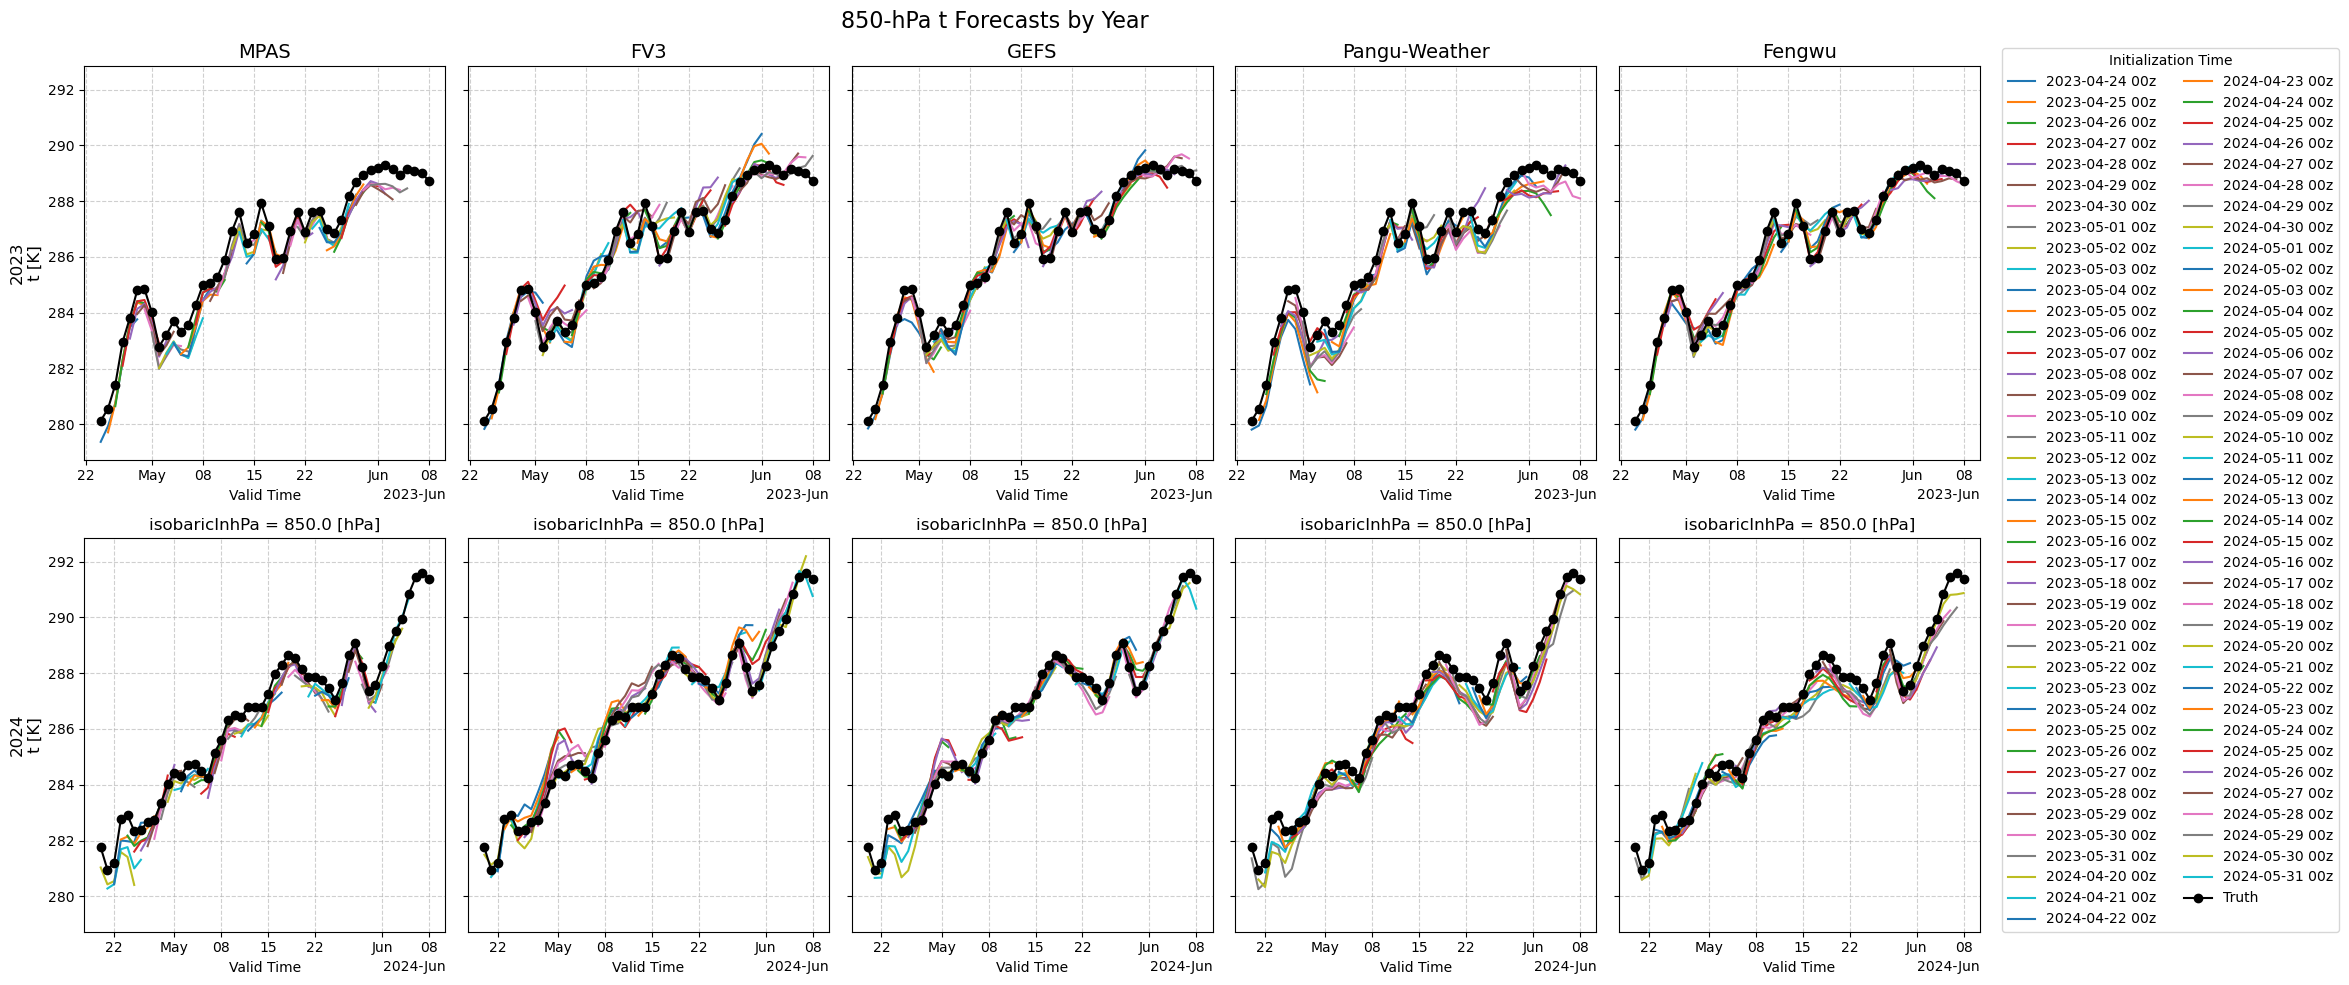

In [11]:
# This code assumes the following variables are already loaded in your script:
# ds_gefs, ds_pangu, ds_fengwu, ds_mpas: xarray.Dataset objects with model data
# truth: xarray.Dataset with the ground truth data
# shortName: A string representing the variable name (e.g., 't' for temperature)
# units: A string for the y-axis label (e.g., 'K' for Kelvin)
# isobaricInhPa: An integer representing the pressure level (e.g., 500)


# These will store the handles and labels for the shared legend
handles = []
labels = []

# --- Define models and years to iterate over ---
models_data = [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu]
model_titles = ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu"]

# --- Plotting Setup ---
# Create a nxm grid of subplots: n rows (for years), m columns (for models)
fig, axes = plt.subplots(nrows=len(years), ncols=len(models_data), figsize=(20, 10), sharey=True)


# --- Main Loop: Iterate over years and models ---
# Loop over each year to create a row of plots
for row_idx, year in enumerate(years):
    # Loop over each model to create a plot in the corresponding column
    for col_idx, (ds_model, title) in enumerate(zip(models_data, model_titles)):
        ax = axes[row_idx, col_idx]

        # --- Data processing steps (as before) ---
        ensemble_mean = ds_model.mean(dim=["number", "latitude", "longitude"])
        stacked_ds = ensemble_mean.stack(point=("initialization_time", "forecast_hour"))
        tidy_ds = stacked_ds.set_index(point=["initialization_time", "valid_time"])
        plot_ready_full = tidy_ds[shortName].unstack("point")

        # --- Filter data for the specific year ---
        # Use xarray's .sel() method for selection instead of pandas' .index
        plot_ready = plot_ready_full.sel(valid_time=plot_ready_full.valid_time.dt.year == year)
        truth_filtered = truth.sel(valid_time=truth.valid_time.dt.year == year)

        # --- Plotting ---
        # Plot the model forecast lines
        # Use .size to check if an xarray DataArray has data
        assert plot_ready.size > 0
        plot_ready.plot.line(
            x="valid_time",
            hue="initialization_time",
            ax=ax,
            add_legend=False,
        )
        # Plot the truth data
        assert truth_filtered[shortName].size > 0
        truth_filtered[shortName].mean(dim=["latitude", "longitude"]).plot.line(
            ax=ax, x="valid_time", marker="o", color="k"
        )

        # --- Axis formatting ---
        # Set the model title for the top row plots only
        if row_idx == 0:
            ax.set_title(title, fontsize=14)

        # Set the y-axis label to include the year on the leftmost plot of each row
        if col_idx == 0:
            ax.set_ylabel(f"{year}\n{shortName} [{units}]", fontsize=12)
        else:
            ax.set_ylabel("")  # Hide y-label for other plots in the row

        ax.set_xlabel("Valid Time")
        ax.grid(True, linestyle="--", alpha=0.6)

        # --- Capture handles and labels ONCE from the first valid plot ---
        if not handles and ax.get_lines():
            all_lines = ax.get_lines()
            truth_line = all_lines[-1]  # The last line plotted is the 'truth' line
            forecast_lines = all_lines[:-1]  # The other lines are the forecasts

            handles.extend(forecast_lines)
            handles.append(truth_line)

            # Create labels for forecast lines
            forecast_labels = [
                pd.to_datetime(t).strftime("%Y-%m-%d %Hz")
                for t in plot_ready.initialization_time.values
            ]
            labels.extend(forecast_labels)
            labels.append("Truth")  # Add the label for the truth line

# --- Final Figure Adjustments ---
# Add a shared legend to the right of the figure
fig.legend(
    handles,
    labels,
    title="Initialization Time",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    ncols=len(years),
)

# Add a main title for the entire figure
fig.suptitle(f"{isobaricInhPa}-hPa {shortName} Forecasts by Year", fontsize=16)

# Adjust layout to make room for the legend and suptitle
fig.tight_layout()

plt.savefig(PLOTDIR / f"ensmean_{isobaricInhPa}{shortName}_{years}.png", dpi=300)

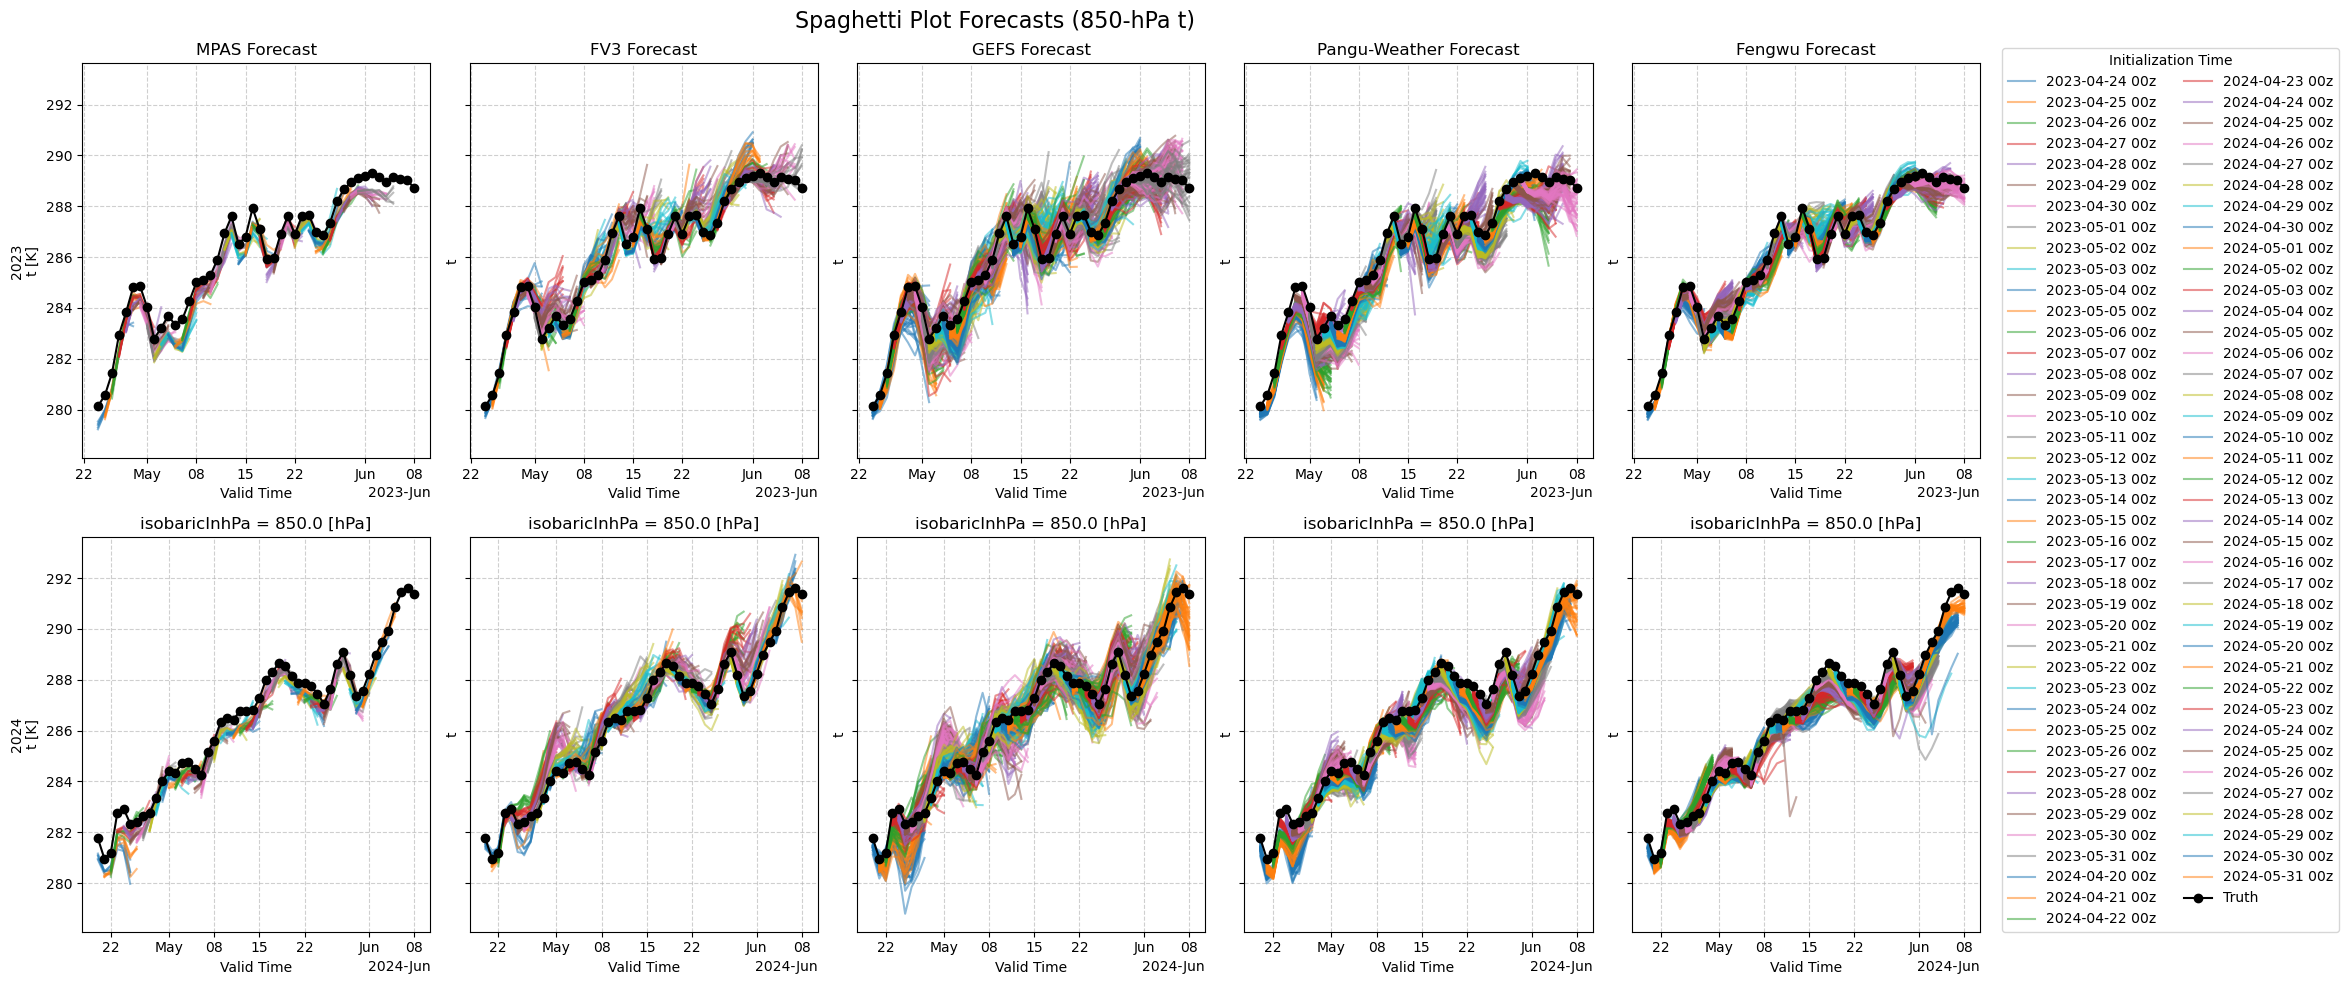

In [12]:
# Assume the following variables are pre-defined from previous cells:
# ds_gefs, ds_pangu, ds_fengwu, ds_mpas, truth, shortName, units, isobaricInhPa


# --- Define models and years to iterate over ---
models_data = [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu]
model_titles = ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu"]

# --- Plotting Setup ---
fig, axes = plt.subplots(
    nrows=len(years), ncols=len(models_data), figsize=(20, 10), sharex=False, sharey=True
)

# --- Legend Handling Setup ---
# These will store the handles and labels for the final shared legend
fig_handles = []
fig_labels = []
truth_handle_info = None # To ensure the 'Truth' entry is added only once

# --- Main Loop: Iterate over years (rows) and models (columns) ---
for row_idx, year in enumerate(years):
    for col_idx, (ds_model, title) in enumerate(zip(models_data, model_titles)):
        ax = axes[row_idx, col_idx]

        ds_processed = ds_model.mean(dim=["latitude", "longitude"])

        # Filter the spatially-averaged data by the initialization year
        ds_model_year = ds_processed.sel(initialization_time=ds_processed.initialization_time.dt.year == year)
        # Filter the truth data by the valid time year
        truth_year = truth.sel(valid_time=truth.valid_time.dt.year == year)

        # Loop over each initialization time in the filtered data
        for init_time in ds_model_year.initialization_time:
            run_with_members = ds_model_year.sel(initialization_time=init_time)
            first_member_data = run_with_members.isel(number=0)

            line = ax.plot(
                first_member_data.valid_time,
                first_member_data[shortName],
                alpha=0.5,
                label=pd.to_datetime(init_time.values).strftime("%Y-%m-%d %Hz"),
            )
            run_color = line[0].get_color()

            for member_index in ds_model_year.number[1:]:
                member_data = run_with_members.sel(number=member_index)
                ax.plot(
                    member_data.valid_time,
                    member_data[shortName],
                    alpha=0.5,
                    color=run_color,
                )

        # Plot the "truth" data ONCE per subplot
        truth_year[shortName].mean(dim=["latitude", "longitude"]).plot.line(
            ax=ax, x="valid_time", marker="o", color="k", label="Truth"
        )

        # --- Axis Formatting ---
        if row_idx == 0:
            ax.set_title(f"{title} Forecast")
        if col_idx == 0:
            ax.set_ylabel(f"{year}\n{shortName} [{units}]")

        ax.set_xlabel("Valid Time")
        ax.grid(True, linestyle="--", alpha=0.6)

        # Capture handles and labels from the first column of EACH row
        if col_idx == 0:
            handles, labels = ax.get_legend_handles_labels()

            # Find and separate the 'Truth' line information
            if "Truth" in labels:
                truth_idx = labels.index("Truth")
                # Store the truth handle only the first time we see it
                if not truth_handle_info:
                    truth_handle_info = (handles.pop(truth_idx), labels.pop(truth_idx))
                else: # Otherwise, just remove it
                    handles.pop(truth_idx)
                    labels.pop(truth_idx)

            fig_handles.extend(handles)
            fig_labels.extend(labels)

# --- Final Legend Assembly ---
# Add the single 'Truth' entry back at the end of the list
if truth_handle_info:
    fig_handles.append(truth_handle_info[0])
    fig_labels.append(truth_handle_info[1])

# Add a shared legend to the right of the figure
fig.legend(
    fig_handles,
    fig_labels,
    title="Initialization Time",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncols=2
)

# Adjust main title and layout to make room for the legend
fig.suptitle(f"Spaghetti Plot Forecasts ({isobaricInhPa}-hPa {shortName})", fontsize=16)
fig.tight_layout()

plt.savefig(PLOTDIR / f"spaghetti_{isobaricInhPa}{shortName}_{years}.png", dpi=300)

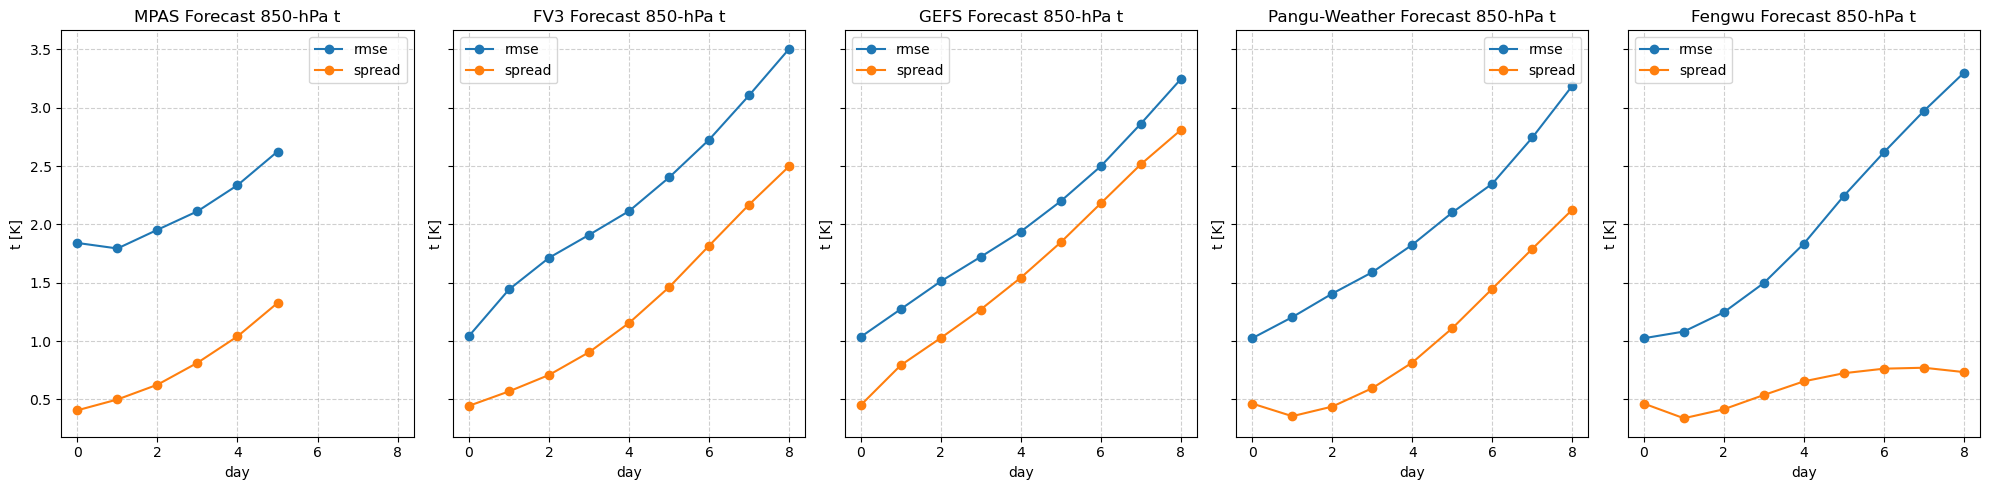

In [13]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 5), sharex=True, sharey=True)

for ax, ds_model, title in zip(
    axes, [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu], ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu"]
):
    ds_model = ds_model.assign_coords(day=ds_model.forecast_hour / 24)

    # select 0.5-deg grid of GEFS or pangu fhr=0 has higher RMSE (because I didn't linearly interpolate pl fields from 0.5 to 0.25-deg grid in pangu input?)
    ds_model = ds_model.sel(latitude=ds_gefs.latitude, longitude=ds_gefs.longitude)

    
    # average over initialization_time, spatial dims. std over ensemble (number).
    ensemble_spread = (
        ds_model[shortName]
        .std(dim="number", ddof=1)
        .mean(dim=["initialization_time", "latitude", "longitude"])
    )
    # error = ensemble mean - truth
    # Line up truth and forecast along `valid_time`.
    error = ds_model.mean(dim="number") - truth.sel(valid_time=ds_model["valid_time"])
    se = error[shortName] ** 2
    mse = se.mean(dim=["latitude", "longitude", "initialization_time"])
    rmse = np.sqrt(mse)
    rmse.plot.line(ax=ax, x="day", marker="o", label="rmse")
    ensemble_spread.plot.line(ax=ax, x="day", marker="o", label="spread")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_title(f"{title} Forecast {isobaricInhPa}-hPa {shortName}")
    ax.legend()
    ax.set_ylabel(f"{shortName} [{units}]")
# Adjust layout
plt.tight_layout()

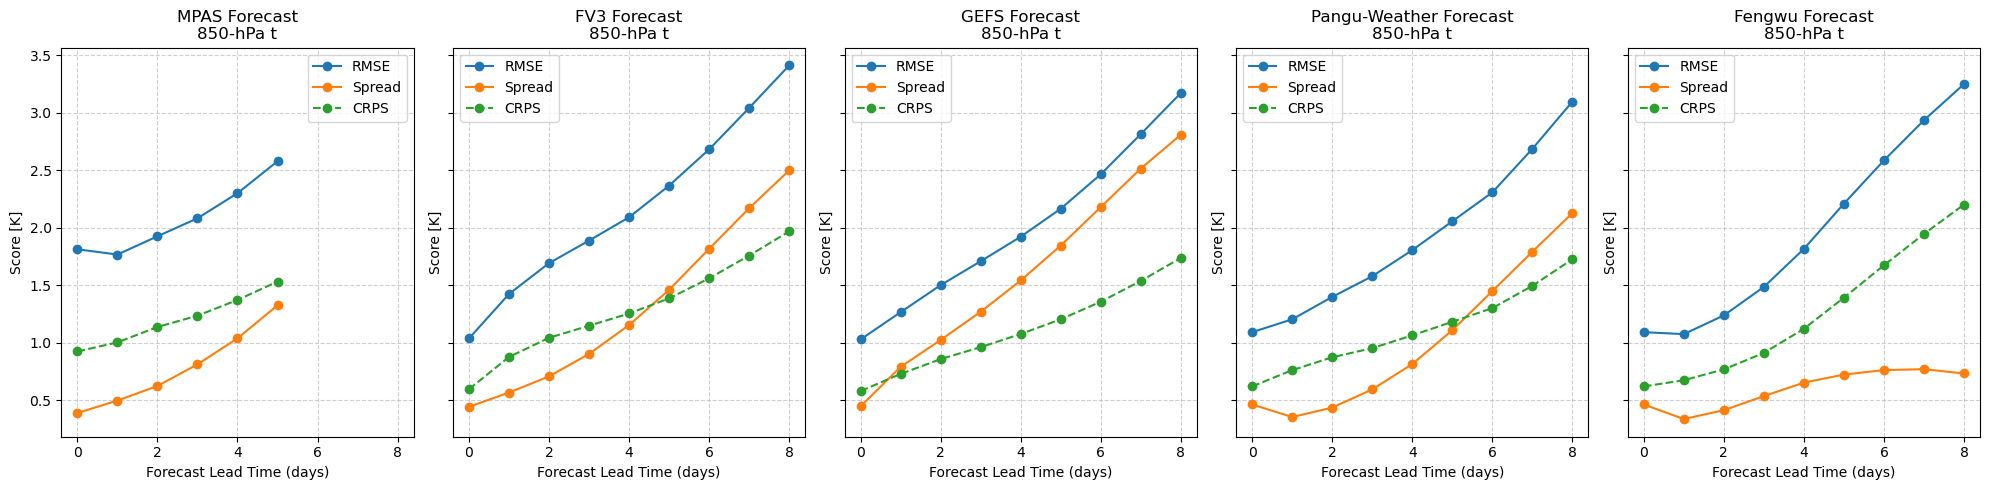

In [14]:
fig, axes = plt.subplots(ncols=5, figsize=(20, 5), sharex=True, sharey=True)

for ax, ds_model, title in zip(
    axes, [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu], ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu"]
):
    # Assign 'day' coordinate for plotting
    ds_model = ds_model.assign_coords(day=ds_model.forecast_hour / 24)

    # Align the truth dataset to the forecast's valid_time for accurate comparison
    # This ensures that for each forecast point, we have a corresponding observation.
    aligned_truth = truth.sel(valid_time=ds_model["valid_time"])

    # --- RMSE and Spread Calculation (Original) ---
    # Calculate ensemble spread: std dev across members, then averaged
    ensemble_spread = (
        ds_model[shortName]
        .std(dim="number", ddof=1)
        .mean(dim=["initialization_time", "latitude", "longitude"])
    )

    # Calculate RMSE: error of ensemble mean vs. truth
    error = ds_model.mean(dim="number") - aligned_truth
    se = error[shortName] ** 2
    mse = se.mean(dim=["latitude", "longitude"])
    rmse = np.sqrt(mse).mean(dim="initialization_time")

    # --- CRPS Calculation (Using properscoring) ---
    # Define the order of non-ensemble dimensions to ensure consistency.
    core_dims = [d for d in ds_model[shortName].dims if d != 'number']

    # Explicitly align and transpose the DataArrays to ensure their underlying
    # numpy arrays have compatible shapes for properscoring.
    aligned_truth_da, forecast_da = xr.align(
        aligned_truth[shortName],
        ds_model[shortName],
        join="inner",
        exclude=["number"]
    )

    # Transpose so that the 'number' dimension is last for the forecast.
    forecast_da = forecast_da.transpose(*core_dims, 'number')
    aligned_truth_da = aligned_truth_da.transpose(*core_dims)

    # Extract the numpy arrays. Their shapes are now guaranteed to be compatible.
    truth_vals = aligned_truth_da.values
    forecast_vals = forecast_da.values

    # Calculate CRPS. The 'number' dimension is now correctly the last axis.
    crps_vals = ps.crps_ensemble(truth_vals, forecast_vals)

    # Convert the resulting numpy array back to an xarray.DataArray.
    # The output of crps_ensemble has the same shape as the observations.
    crps = xr.DataArray(
        crps_vals,
        dims=aligned_truth_da.dims,
        coords=aligned_truth_da.coords
    )

    # Average the CRPS over spatial and time dimensions for a single score per lead time
    crps_mean = crps.mean(dim=["initialization_time", "latitude", "longitude"])

    # --- Plotting ---
    # Plot the original and new metrics
    rmse.plot.line(ax=ax, x="day", marker="o", label="RMSE")
    ensemble_spread.plot.line(ax=ax, x="day", marker="o", label="Spread")
    crps_mean.plot.line(ax=ax, x="day", marker="o", label="CRPS", linestyle="--")

    # --- Formatting ---
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_title(f"{title} Forecast\n{isobaricInhPa}-hPa {shortName}", fontsize=12)
    ax.legend()
    ax.set_ylabel(f"Score [{units}]")
    ax.set_xlabel("Forecast Lead Time (days)")

# Adjust layout
plt.tight_layout()

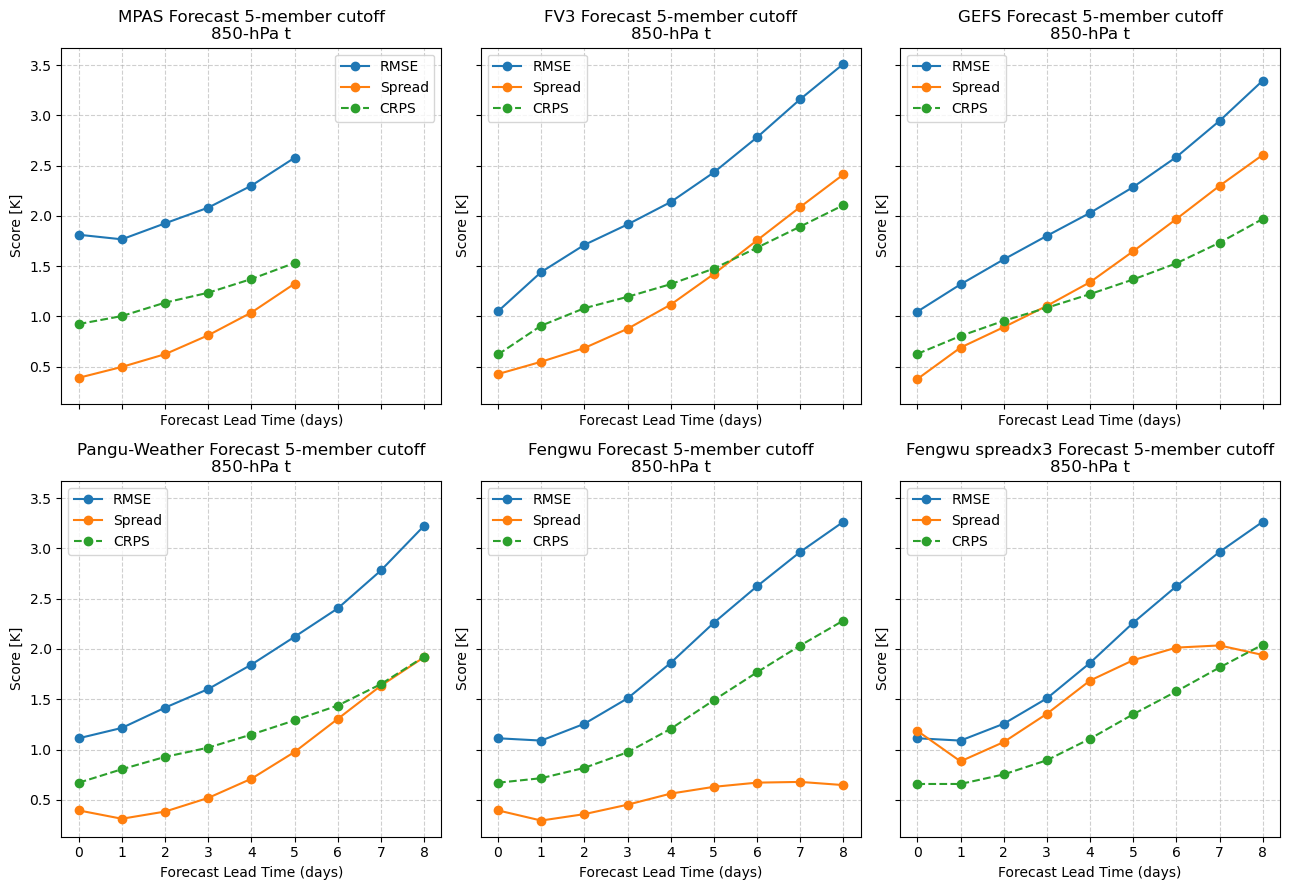

In [15]:
# Truncate members
member_cutoff = 5  # 1, 5, or None

# calculate deviation from the ensemble mean (anomaly)
ds_fengwu_anom = ds_fengwu - ds_fengwu.isel(number=slice(0, member_cutoff)).mean(dim="number")
# inflate the spread about the mean
ds_fengwu_inflated_spread = ds_fengwu.isel(number=slice(0, member_cutoff)).mean(dim="number") + 3*ds_fengwu_anom

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13, 9), sharex=True, sharey=True)

for ax, ds_model, title in zip(
    axes.flat, [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu, ds_fengwu_inflated_spread], ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu", "Fengwu spreadx3"]
):

    # Select only the first 5 ensemble members for evaluation
    ds_model = ds_model.isel(number=slice(0, member_cutoff))

    # Assign 'day' coordinate for plotting
    ds_model = ds_model.assign_coords(day=ds_model.forecast_hour / 24)

    # Align the truth dataset to the forecast's valid_time for accurate comparison
    # This ensures that for each forecast point, we have a corresponding observation.
    aligned_truth = truth.sel(valid_time=ds_model["valid_time"])

    # --- RMSE and Spread Calculation (Original) ---
    # Calculate ensemble spread: std dev across members, then averaged
    ensemble_spread = (
        ds_model[shortName]
        .std(dim="number", ddof=1)
        .mean(dim=["initialization_time", "latitude", "longitude"])
    )

    # Calculate RMSE: error of ensemble mean vs. truth
    error = ds_model.mean(dim="number") - aligned_truth
    se = error[shortName] ** 2
    mse = se.mean(dim=["latitude", "longitude"])
    rmse = np.sqrt(mse).mean(dim="initialization_time")

    # --- CRPS Calculation (Using properscoring) ---
    # Define the order of non-ensemble dimensions to ensure consistency.
    core_dims = [d for d in ds_model[shortName].dims if d != 'number']

    # Explicitly align and transpose the DataArrays to ensure their underlying
    # numpy arrays have compatible shapes for properscoring.
    aligned_truth_da, forecast_da = xr.align(
        aligned_truth[shortName],
        ds_model[shortName],
        join="inner",
        exclude=["number"]
    )

    # Transpose so that the 'number' dimension is last for the forecast.
    forecast_da = forecast_da.transpose(*core_dims, 'number')
    aligned_truth_da = aligned_truth_da.transpose(*core_dims)

    # Extract the numpy arrays. Their shapes are now guaranteed to be compatible.
    truth_vals = aligned_truth_da.values
    forecast_vals = forecast_da.values

    # Calculate CRPS. The 'number' dimension is now correctly the last axis.
    crps_vals = ps.crps_ensemble(truth_vals, forecast_vals)

    # Convert the resulting numpy array back to an xarray.DataArray.
    # The output of crps_ensemble has the same shape as the observations.
    crps = xr.DataArray(
        crps_vals,
        dims=aligned_truth_da.dims,
        coords=aligned_truth_da.coords
    )

    # Average the CRPS over spatial and time dimensions for a single score per lead time
    crps_mean = crps.mean(dim=["initialization_time", "latitude", "longitude"])

    # --- Plotting ---
    # Plot the original and new metrics
    rmse.plot.line(ax=ax, x="day", marker="o", label="RMSE")
    ensemble_spread.plot.line(ax=ax, x="day", marker="o", label="Spread")
    crps_mean.plot.line(ax=ax, x="day", marker="o", label="CRPS", linestyle="--")

    # --- Formatting ---
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_title(f"{title} Forecast {member_cutoff}-member cutoff\n{isobaricInhPa}-hPa {shortName}", fontsize=12)
    ax.legend()
    ax.set_ylabel(f"Score [{units}]")
    ax.set_xlabel("Forecast Lead Time (days)")

# Adjust layout
plt.tight_layout()

plt.savefig(PLOTDIR / f"rmse_spread_crps_fengwu_spreadx3_{isobaricInhPa}{shortName}_{years}.png", dpi=300)

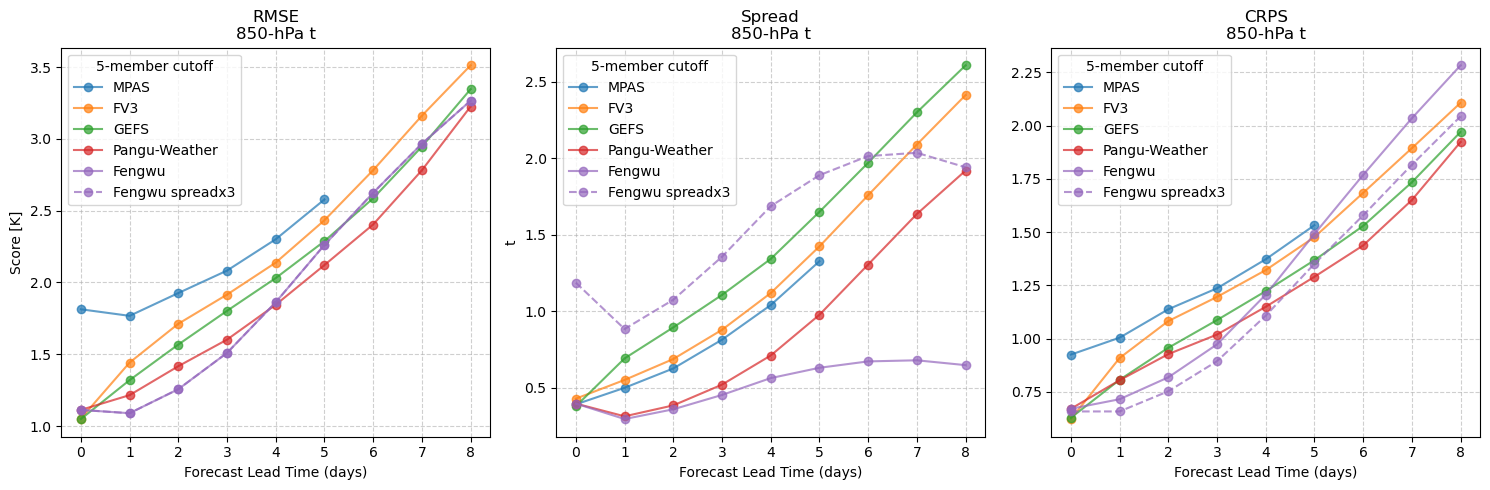

In [16]:
# Define the models and their titles for the legend
datasets = [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu, ds_fengwu_inflated_spread]
titles = ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu", "Fengwu spreadx3"]

# --- Create Subplots: One for each metric ---
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax_rmse, ax_spread, ax_crps = axes

# Variable to store the color of the 'Fengwu' plot
fengwu_color = None

# --- Loop through models, calculate metrics, and plot on the correct panel ---
for ds_model, title in zip(datasets, titles):

    # Select only the first 5 ensemble members for evaluation
    ds_model = ds_model.isel(number=slice(0, member_cutoff))

    # Assign 'day' coordinate for plotting
    ds_model = ds_model.assign_coords(day=ds_model.forecast_hour / 24)

    # Align the truth dataset to the forecast's valid_time for accurate comparison
    aligned_truth = truth.sel(valid_time=ds_model["valid_time"])

    # --- RMSE and Spread Calculation ---
    ensemble_spread = (
        ds_model[shortName]
        .std(dim="number", ddof=1)
        .mean(dim=["initialization_time", "latitude", "longitude"])
    )
    error = ds_model.mean(dim="number") - aligned_truth
    se = error[shortName] ** 2
    mse = se.mean(dim=["latitude", "longitude"])
    rmse = np.sqrt(mse).mean(dim="initialization_time")

    # --- CRPS Calculation ---
    core_dims = [d for d in ds_model[shortName].dims if d != "number"]
    aligned_truth_da, forecast_da = xr.align(
        aligned_truth[shortName], ds_model[shortName], join="inner", exclude=["number"]
    )
    forecast_da = forecast_da.transpose(*core_dims, "number")
    aligned_truth_da = aligned_truth_da.transpose(*core_dims)
    crps_vals = ps.crps_ensemble(aligned_truth_da.values, forecast_da.values)
    crps = xr.DataArray(crps_vals, dims=aligned_truth_da.dims, coords=aligned_truth_da.coords)
    crps_mean = crps.mean(dim=["initialization_time", "latitude", "longitude"])

    # --- Plotting Logic ---
    plot_kwargs = {"marker": "o", "label": title, "alpha": 0.7}

    # Check if the current model is the one to be dashed
    if title == "Fengwu spreadx3":
        plot_kwargs["linestyle"] = "--"
        # Use the stored color from the 'Fengwu' plot
        if fengwu_color:
            plot_kwargs["color"] = fengwu_color

    # Plot each metric and store the color if it's the 'Fengwu' model
    line_rmse = rmse.plot.line(ax=ax_rmse, x="day", **plot_kwargs)
    line_spread = ensemble_spread.plot.line(ax=ax_spread, x="day", **plot_kwargs)
    line_crps = crps_mean.plot.line(ax=ax_crps, x="day", **plot_kwargs)

    # If we just plotted 'Fengwu', get its color for the next iteration
    if title == "Fengwu":
        # The plot function returns a list of lines; get the color from the first one
        fengwu_color = line_rmse[0].get_color()


# --- Formatting for all subplots ---
for ax in axes:
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title=f"{member_cutoff}-member cutoff")
    ax.set_xlabel("Forecast Lead Time (days)")

# Set titles and y-axis label for each panel
ax_rmse.set_title(f"RMSE\n{isobaricInhPa}-hPa {shortName}", fontsize=12)
ax_spread.set_title(f"Spread\n{isobaricInhPa}-hPa {shortName}", fontsize=12)
ax_crps.set_title(f"CRPS\n{isobaricInhPa}-hPa {shortName}", fontsize=12)

ax_rmse.set_ylabel(f"Score [{units}]")

# Adjust layout
plt.tight_layout()

plt.savefig(PLOTDIR / f"rmse_spread_crps_all_models_on_same_panel_{member_cutoff}-member_cutoff_{isobaricInhPa}{shortName}_{years}.png", dpi=300)

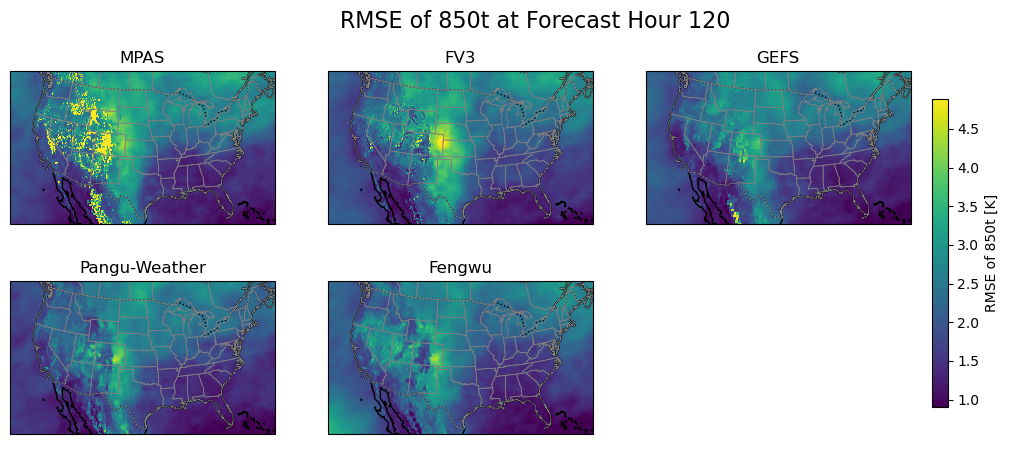

In [19]:
# --- Main Logic ---
datasets = [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu]
titles = ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu"]

# --- 1. Pre-calculate all RMSE arrays to find a global color scale ---
all_rmse_maps = []
for ds_model, title in zip(datasets, titles):
    # Align the truth dataset to the forecast's valid_time
    aligned_truth = truth.sel(valid_time=ds_model["valid_time"], method="nearest")

    # Calculate error and RMSE, but keep spatial dimensions
    error = ds_model.mean(dim="number") - aligned_truth
    se = error[shortName] ** 2
    # Average over initialization time to get a stable RMSE map for each forecast hour
    mse = se.mean(dim=["initialization_time"])
    rmse = np.sqrt(mse)
    all_rmse_maps.append(rmse)

# Select the forecast hour to plot (e.g., the last one)
fhr_to_plot = ds_mpas.forecast_hour.values[-1]
rmse_maps_at_fhr = [rmse.sel(forecast_hour=fhr_to_plot) for rmse in all_rmse_maps]

# Determine a robust color range using percentiles to avoid outliers skewing the scale
# First, combine all data into a single array
all_rmse_values = np.concatenate([da.values.ravel() for da in rmse_maps_at_fhr])
all_rmse_values = all_rmse_values[~np.isnan(all_rmse_values)]
# Then calculate the 2nd and 98th percentiles
vmin = np.percentile(all_rmse_values, 1)
vmax = np.percentile(all_rmse_values, 99.5)

# --- 2. Create the plots ---
fig, axes = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(14, 5),
    subplot_kw={
        "projection": ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.5)
    },
)

for i, (ax, ds_model, title) in enumerate(zip(axes.flat, datasets, titles)):
    rmse_map = rmse_maps_at_fhr[i]

    # Plot the 2D RMSE map
    im = rmse_map.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
        add_colorbar=False,  # We will add a single colorbar later
    )

    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.STATES, edgecolor="gray", lw=0.5)

    # Set title for each subplot
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")

    extent = [-124, -72, 25, 50]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

# Hide any unused subplots
for i in range(len(datasets), len(axes.flat)):
    axes.flat[i].axis("off")

# Add a single, shared colorbar for the entire figure
fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    label=f"RMSE of {isobaricInhPa}{shortName} [{units}]",
    shrink=0.8,
    pad=0.02,
)

# Adjust layout
plt.suptitle(f"RMSE of {isobaricInhPa}{shortName} at Forecast Hour {fhr_to_plot}", fontsize=16)
plt.savefig(PLOTDIR / f"spatial_rmse_{isobaricInhPa}{shortName}_{years}.png", dpi=300)

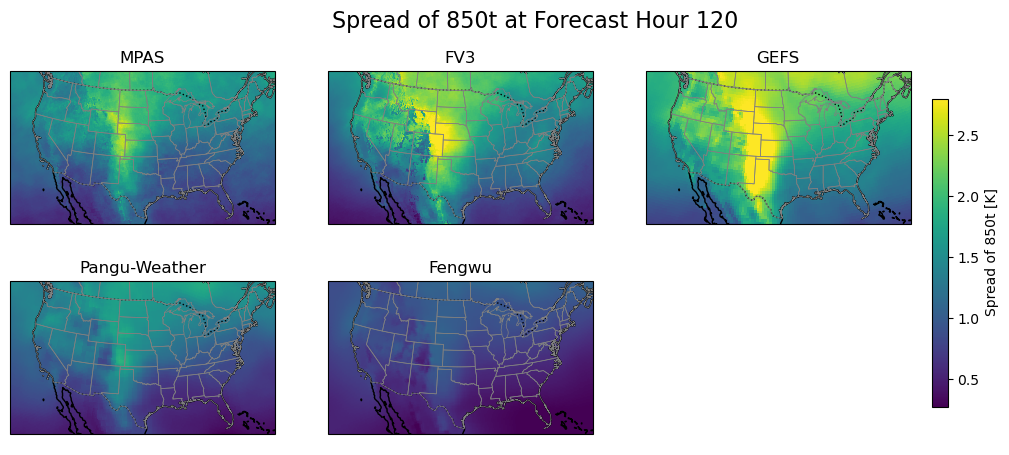

In [20]:
# --- 1. Pre-calculate all Spread arrays to find a global color scale ---
all_spread_maps = []
for ds_model, title in zip(datasets, titles):
    # Calculate ensemble spread, keeping spatial dimensions
    # Average over initialization_time to get a stable spread map for each forecast hour
    ensemble_spread = (
        ds_model[shortName]
        .std(dim="number", ddof=1)
        .mean(dim=["initialization_time"])
    )
    all_spread_maps.append(ensemble_spread)

# Select the forecast hour to plot (e.g., the last one)
fhr_to_plot = ds_mpas.forecast_hour.values[-1]
spread_maps_at_fhr = [spread.sel(forecast_hour=fhr_to_plot) for spread in all_spread_maps]

# Determine a robust color range using percentiles to avoid outliers skewing the scale
# First, combine all data into a single array
all_spread_values = np.concatenate([da.values.ravel() for da in spread_maps_at_fhr])
all_spread_values = all_spread_values[~np.isnan(all_spread_values)]
# Then calculate the 1st and 99.5th percentiles
vmin = np.percentile(all_spread_values, 1)
vmax = np.percentile(all_spread_values, 99.5)


# --- 2. Create the plots ---
fig, axes = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(14, 5),
    subplot_kw={"projection": ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.5)}
)

for i, (ax, ds_model, title) in enumerate(zip(axes.flat, datasets, titles)):
    spread_map = spread_maps_at_fhr[i]
    
    # Plot the 2D Spread map
    im = spread_map.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
        add_colorbar=False  # We will add a single colorbar later
    )
    
    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='gray', lw=0.5)
    
    # Set title for each subplot
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")

    extent = [-124, -72, 25, 50]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

# Hide any unused subplots
for i in range(len(datasets), len(axes.flat)):
    axes.flat[i].axis('off')

# Add a single, shared colorbar for the entire figure
# Note: colorbar is attached to the whole figure, not just the populated axes
fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', label=f"Spread of {isobaricInhPa}{shortName} [{units}]", shrink=0.8, pad=0.02)

# Adjust layout
plt.suptitle(f"Spread of {isobaricInhPa}{shortName} at Forecast Hour {fhr_to_plot}", fontsize=16)
plt.savefig(PLOTDIR / f"spatial_spread_{isobaricInhPa}{shortName}_{years}.png", dpi=300)